In [1]:
# NOTICE!!!!
# replace 'E' in the equation with 'e' as sympy would treat 'E' as numerical value e.
##################

import sympy as sp
import pandas as pd

# Define custom operations using subclassing of sympy.Function
class Add(sp.Function):
    @classmethod
    def eval(cls, x, y):
        return x + y

class Sub(sp.Function):
    @classmethod
    def eval(cls, x, y):
        return x - y

class Mul(sp.Function):
    @classmethod
    def eval(cls, x, y):
        return x * y

class Div(sp.Function):
    @classmethod
    def eval(cls, x, y):
        try:
            result = sp.Piecewise(
                (1, sp.Eq(y, 0)),  # Return 1 if y is exactly zero
                (1, sp.Eq(y, sp.zoo)),  # Return 1 if y is exactly zero
                (x / y, True)           # Normal division otherwise
            )
            return result.simplify()  # Simplify to handle potential further issues
        except Exception as e:
            print(f"Division error: {e}")
            return 1000  # Return NaN on error
        
# Define the custom operations using subclassing of sympy.Function
class Div_for_visualization(sp.Function):
    @classmethod
    def eval(cls, x, y):
        # Use Piecewise to handle division by zero robustly
        return x / y

class Neg(sp.Function):
    @classmethod
    def eval(cls, x):
        return -x
    

# Update converter for sympify to recognize custom classes
converter = {
    'add': Add,
    'sub': Sub,
    'mul': Mul,
    'div': Div,
    'neg': Neg,
}

# Update converter for sympify to recognize custom classes
converter_vis = {
    'add': Add,
    'sub': Sub,
    'mul': Mul,
    'div': Div_for_visualization,
    'neg': Neg,
}

# Function to apply the equation to each row of the DataFrame
def apply_equation(row):
    # Replace variables in the expression with row data
    local_env = {
        'Pr': row['Pr'],
        'La': row['La'],
        'Gd': row['Gd'],
        'Nd': row['Nd'],
        'Ce': row['Ce'],
        'Sm': row['Sm'],
        'Y' : row['Y'],
        "EN": row['EN'],
        'R' : row['R'],
        'IE': row['IE'],
        'LAS': row['LAS'],
        'M' : row['M'],
        'e' : row['E'],
    }
    try:
        result = expr.subs(local_env)
        # Force numeric evaluation if the result is not numeric
        if isinstance(result, sp.Expr):  # Check if result is still a symbolic expression
            result = result.evalf()  # Evaluate numerically
        # if result == sp.zoo:
        #     result = 1
    except Exception as e:
        print(f"Error evaluating row: {local_env}")
        print(f"Error message: {str(e)}")
        result = None  # Optional: handle error case by assigning a default value or None
    return result

    # print("Local Environment:", local_env)  # Debug: Print the local environment for a row
    # return expr.subs(local_env)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pickle

0.288184438040346*Pr + 0.711815561959654*e + (EN*Nd/Y - Y)/La
[1.49294543 1.20380354 1.02549632] -11.351311505998446
RMSE: 0.7594617766460251
RMSE_original: 0.02737666656976306
R^2 score: 0.4232148210536013


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


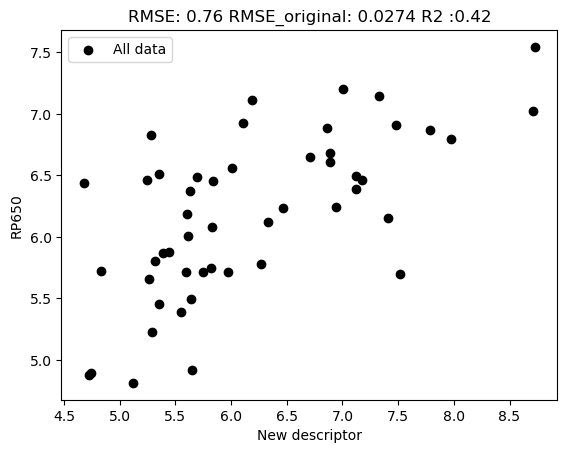

In [3]:
equ = "add(div(sub(mul(EN, div(Nd, Y)), Y), La), add(div(sub(Pr, e), 3.470), e))"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./all_rp650.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("Pr", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("e", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("(EN*Nd/Y - Y)/La", locals=converter,evaluate=True)
df['c'] = df.apply(apply_equation, axis=1)


# Use the second column as X and the first as Y
X = df.iloc[:, -3:].values
Y = df.iloc[:, -4].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[2]
    std = scaler.scale_[2]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='All data')
plt.xlabel('New descriptor')
plt.ylabel('RP650')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('all_rp650_pred_split.xlsx', index=False)


EN + 6.424/(Sm + 0.466/(La - R))
[1.07240461 6.50881964] -0.41195549040691226
RMSE: 0.6304176638095371
RMSE_original: 0.022724954319652022
R^2 score: 0.5630273776373018


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


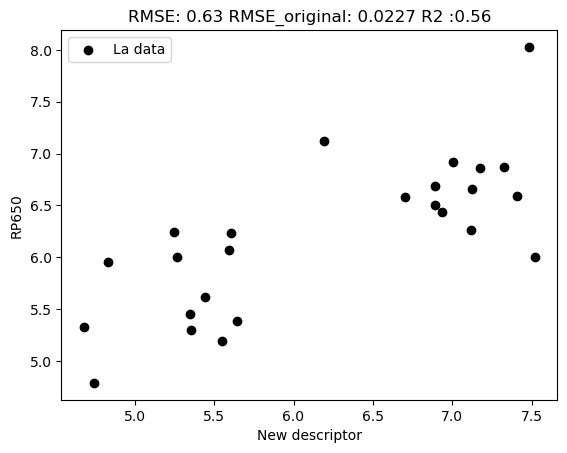

In [4]:
equ = "add(div(6.424, add(Sm, div(0.466, sub(La, R)))), EN)"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./La_rp650.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("EN", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("1/(Sm + 0.466/(La - R))", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)

# Use the second column as X and the first as Y
X = df.iloc[:, -2:].values
Y = df.iloc[:, -3].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[2]
    std = scaler.scale_[2]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='La data')
plt.xlabel('New descriptor')
plt.ylabel('RP650')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('La_rp650_pred_split.xlsx', index=False)

0.286697247706422*Pr - 0.286697247706422*Y + e + (EN - IE)/(Y*(EN - Sm))
[-0.22851263 -0.33583655  0.75092387  0.97359887] 5.475677753840093
RMSE: 0.5737871160537946
RMSE_original: 0.02068356702242849
R^2 score: 0.7471178404395274


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


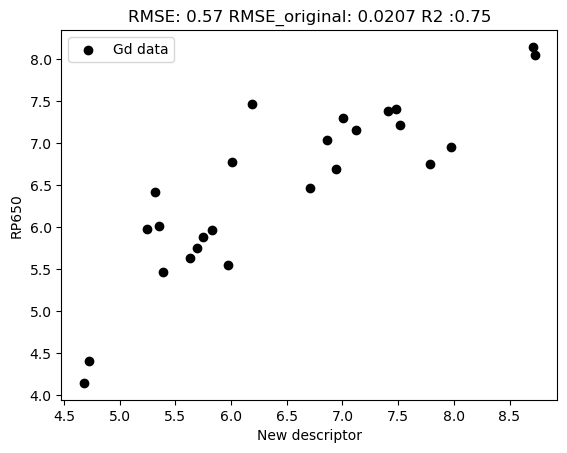

In [6]:
equ = "add(div(sub(Pr, Y), 3.488), add(div(div(sub(EN, IE), sub(EN, Sm)), Y), e))"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./Gd_rp650.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("Pr", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("Y", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("e", locals=converter,evaluate=True)
df['c'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("(EN - IE)/(Y*(EN - Sm))", locals=converter,evaluate=True)
df['d'] = df.apply(apply_equation, axis=1)

# Use the second column as X and the first as Y
X = df.iloc[:, -4:].values
Y = df.iloc[:, -5].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[2]
    std = scaler.scale_[2]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='Gd data')
plt.xlabel('New descriptor')
plt.ylabel('RP650')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('Gd_rp650_pred_split.xlsx', index=False)

e + (6.163 - Y)*(-La + Y)/(7.642*EN - 7.642*Y) + 0.212
[0.679911   0.82526338] 2.3869195559219225
RMSE: 0.7978641459672895
RMSE_original: 0.028760974368688883
R^2 score: 0.3862706703355132


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


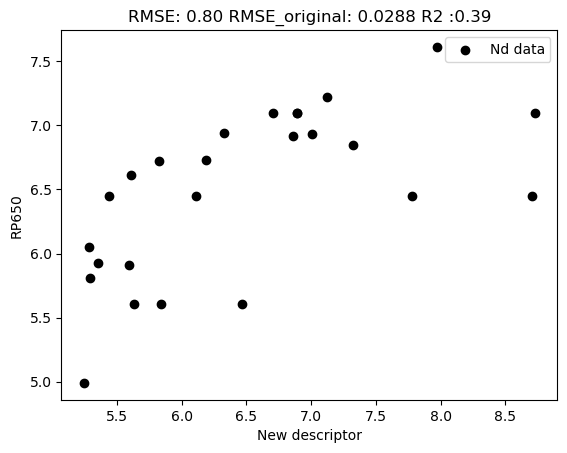

In [7]:
equ = "add(div(sub(6.163, Y), div(mul(sub(EN, Y), 7.642), sub(Y, La))), add(e, 0.212))"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./Nd_rp650.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("e", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("(6.163 - Y)*(-La + Y)/(7.642*EN - 7.642*Y)", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)

# Use the second column as X and the first as Y
X = df.iloc[:, -2:].values
Y = df.iloc[:, -3].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[2]
    std = scaler.scale_[2]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='Nd data')
plt.xlabel('New descriptor')
plt.ylabel('RP650')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('Nd_rp650_pred_split.xlsx', index=False)

0.102333196889071*Gd/(La*(LAS - M)) + 0.766791044776119*M + 0.233208955223881*e
Gd/(La*(LAS - M))
M
e
[0.10659737 0.80561438 0.39421114] -1.2282497212630048
RMSE: 0.7088828229142086
RMSE_original: 0.02555342385453581
R^2 score: 0.498392151042799


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


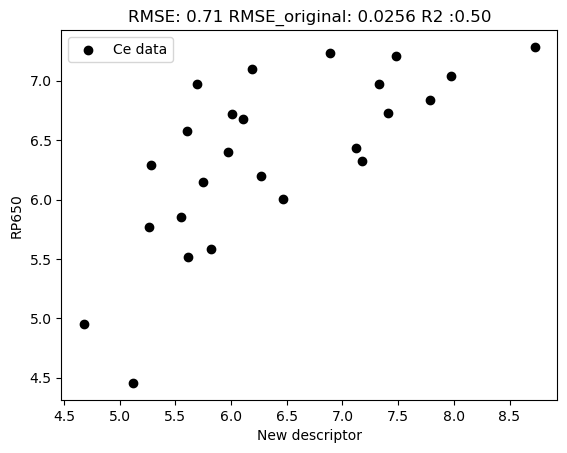

In [10]:
equ = "add(div(sub(e, M), 4.288), add(div(div(Gd, 4.886), mul(sub(LAS, M), add(La, La))), M))"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./Ce_rp650.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("Gd/(La*(LAS - M))", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)
print(expr)

expr = sp.sympify("M", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)
print(expr)

expr = sp.sympify("e", locals=converter,evaluate=True)
df['c'] = df.apply(apply_equation, axis=1)
print(expr)

# Use the second column as X and the first as Y
X = df.iloc[:, -3:].values
Y = df.iloc[:, -4].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
# model.coef_ = np.array([-1]) 
# model.intercept_ = 6.986 
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[2]
    std = scaler.scale_[2]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='Ce data')
plt.xlabel('New descriptor')
plt.ylabel('RP650')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('Ce_rp650_pred_split.xlsx', index=False)

e + (M - e)/(La - 2.843) + 3.325/(IE*Nd*(R - Y))
[0.99188236 0.93661372 3.48953222] 0.09865834689659891
RMSE: 0.6239987904010599
RMSE_original: 0.02249357024943132
R^2 score: 0.6135004278971661


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


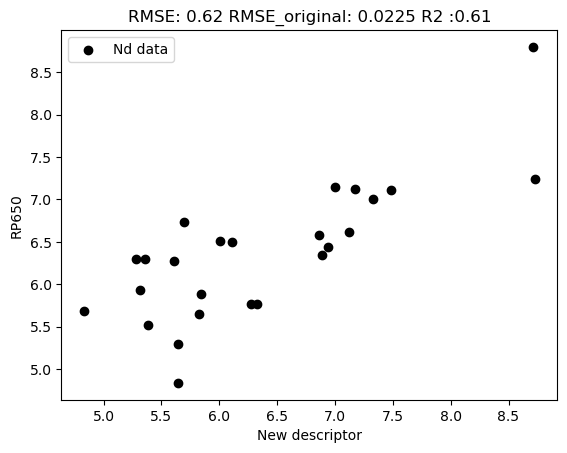

In [11]:
equ = "add(div(3.325, mul(sub(R, Y), mul(Nd, IE))), add(div(sub(M, e), add(La, -2.843)), e))"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./Sm_rp650.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("e", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("(M - e)/(La - 2.843)", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("1/(IE*Nd*(R - Y))", locals=converter,evaluate=True)
df['c'] = df.apply(apply_equation, axis=1)

# Use the second column as X and the first as Y
X = df.iloc[:, -3:].values
Y = df.iloc[:, -4].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[2]
    std = scaler.scale_[2]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='Nd data')
plt.xlabel('New descriptor')
plt.ylabel('RP650')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('Sm_rp650_pred_split.xlsx', index=False)

e + (Ce - Y + e - 5.698)/(Nd*(-IE + La))
[0.84609765 0.97801902] 0.808699209021297
RMSE: 0.5051582787414902
RMSE_original: 0.00846181901105499
R^2 score: 0.7043123540423728


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


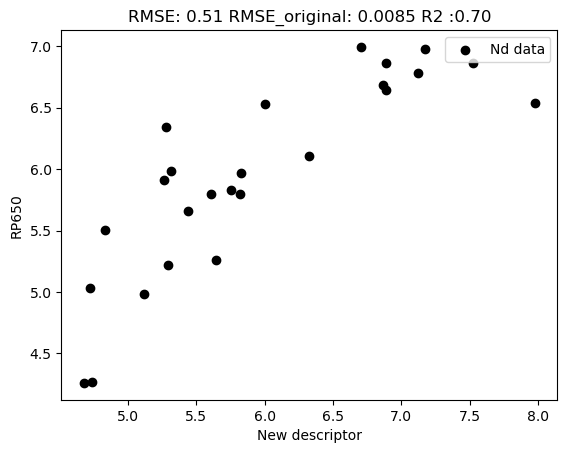

In [12]:
equ = "add(div(sub(e, add(sub(5.698, Ce), Y)), mul(sub(La, IE), Nd)), e)"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./Y_rp650.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("e", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("(Ce - Y + e - 5.698)/(Nd*(-IE + La))", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)


# Use the second column as X and the first as Y
X = df.iloc[:, -2:].values
Y = df.iloc[:, -3].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[1]
    std = scaler.scale_[1]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='Nd data')
plt.xlabel('New descriptor')
plt.ylabel('RP650')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('Y_rp650_pred_split.xlsx', index=False)